In [31]:
import numpy as np
import casadi as ca
import 

SyntaxError: invalid syntax (<ipython-input-31-d45fcfb796f8>, line 3)

In [32]:
m = 10
N = 30
Nd = 1
K = 2
rho = 10
alpha = 0.2

In [33]:
x = ca.SX.sym("x",m)
tau = ca.SX.sym("tau",1)
lambda_ =  ca.SX.sym("lambda_",1)
s = ca.SX.sym("s",N)
gamma_ik = [ [ca.SX.sym("s"+str(i)+'_'+str(j),Nd) for i in range(N)] for j in range(K)]

In [34]:
gamma_ik[1][0].shape

(1, 1)

In [35]:
# eps = cp.Parameter(nonneg=True)
eps = 1
a1 = -1
a2 = -1 - rho/alpha
b1 = rho
b2 = rho * (1 - 1/alpha)
a = [a1, a2]
b = [b1, b2]

C = np.zeros((Nd,m))
d = np.zeros((Nd,1))

In [36]:
C

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
# eps = cp.Parameter(nonneg=True)
eps_SX = ca.SX.sym("eps",1)
a_SX = ca.SX.sym("a",K)
b_SX = ca.SX.sym("b",K)
C_SX = ca.SX.sym('C',Nd,m)
d_SX = ca.SX.sym('d',Nd)

In [38]:
# np.random.seed(1)
xi_hat_list = []
for i in range(N):
    psi = np.sqrt(0.02) * np.random.randn(1)
    xi_temp_list = []
    for j in range(m):
        zeta_i = np.sqrt(j * 0.025) * np.random.randn(1) + j * 0.03
        xi = psi + zeta_i
        xi_temp_list += [xi]
    xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]

In [39]:
xi_hat_list_SX = ca.SX.sym("xi",m,N)
xi_hat_list_SX[:,0]

SX([xi_0, xi_1, xi_2, xi_3, xi_4, xi_5, xi_6, xi_7, xi_8, xi_9])

In [40]:
obj = lambda_ * eps_SX + 1/N * ca.sum1(s)

x_dec = ca.vertcat(x, tau, lambda_, s, *sum(gamma_ik,[]))

In [41]:
g = []    
g += [ca.sum1(x)-1]
for k in range(K):
    for i in range(N):
        g += [b_SX[k]*tau + a_SX[k] * x.T @ xi_hat_list_SX[:, i] + gamma_ik[k][i].T @ (d_SX - C_SX @ xi_hat_list_SX[:, i]) - s[i]]
        g += [ca.norm_inf(C_SX.T @ gamma_ik[k][i] - a_SX[k] * x ) - lambda_ ]
        g += [gamma_ik[k][i]]
g = ca.vertcat(*g)

p = ca.vertcat(eps_SX,a_SX,b_SX, ca.reshape(C_SX,-1,1), d_SX, ca.reshape(xi_hat_list_SX,-1,1))

In [42]:

# Define proximal solver
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-10,
    'acceptable_obj_change_tol': 1e-10
}

nlp = {'x':x_dec, 'g':g, 'f':obj,'p':p}
#     print(nlp)
solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opt)


In [43]:
nl_opt = {}
# nl_opt['x0'] = ca.vertcat(*xi_list)

nl_opt['x0'] = [0.1] * m + [0]* (1 + 1 + N + Nd * N * K)

nl_opt['lbx'] = [0] * m 
nl_opt['ubx'] = [+ca.inf] * m 

nl_opt['lbx'] += [-ca.inf] * (1 + 1 + N + Nd * N * K)
nl_opt['ubx'] += [+ca.inf] * (1 + 1 + N + Nd * N * K)

nl_opt['lbg'] = [0]
nl_opt['ubg'] = [0]

for k in range(K):
    for i in range(N):
        nl_opt['lbg'] += [-ca.inf]
        nl_opt['lbg'] += [-ca.inf]
        nl_opt['lbg'] += [0]
        
        nl_opt['ubg'] += [0]
        nl_opt['ubg'] += [0]
        nl_opt['ubg'] += [ca.inf]
        
nl_opt['p'] = [eps, a1, a2, b1, b2] + C.flatten().tolist() + d.flatten().tolist() + ca.vertcat(*xi_hat_list).full().flatten().tolist()

In [46]:
N_sim = 30
x_sum = ca.DM.zeros(m)
x_ave_list = []

# eps_scale = np.logspace(-3, 0, 10, endpoint=True)
eps = 1

for _ in range(N_sim):
    xi_hat_list = []
    for i in range(N):
        psi = np.sqrt(0.02) * np.random.randn(1)
        xi_temp_list = []
        for j in range(m):
            zeta_i = np.sqrt((j+1) * 0.025) * np.random.randn(1) + (j+1) * 0.03
            xi = psi + zeta_i
            xi_temp_list += [xi]
        xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]


    nl_opt['p'] = [eps, a1, a2, b1, b2] + C.flatten().tolist() + d.flatten().tolist() + ca.vertcat(*xi_hat_list).full().flatten().tolist()
    x_sum += solver(**nl_opt)['x'][:m]
print(x_sum/N_sim)



[0.075183, 0.0810924, 0.0864332, 0.0886904, 0.107834, 0.114941, 0.119975, 0.102144, 0.116566, 0.10714]


In [47]:
N_sim = 30
x_ave_list = []

eps_scale = np.logspace(-3, 0, 10, endpoint=True)
for eps in eps_scale:
    x_sum = ca.DM.zeros(m)
    print(eps)
    for _ in range(N_sim):
        xi_hat_list = []
        for i in range(N):
            psi = np.sqrt(0.02) * np.random.randn(1)
            xi_temp_list = []
            for j in range(m):
                zeta_i = np.sqrt((j+1) * 0.025) * np.random.randn(1) + (j+1) * 0.03
                xi = psi + zeta_i
                xi_temp_list += [xi]
            xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]


        nl_opt['p'] = [eps, a1, a2, b1, b2] + C.flatten().tolist() + d.flatten().tolist() + ca.vertcat(*xi_hat_list).full().flatten().tolist()
        x_sum += solver(**nl_opt)['x'][:m]
    x_ave_list += [x_sum/N_sim]



0.001
0.0021544346900318843
0.004641588833612777
0.01
0.021544346900318832
0.046415888336127774
0.1
0.21544346900318823
0.46415888336127775
1.0


In [48]:
x_ave_list

[DM([0.00393628, 0.043067, 0.0756781, 0.0894802, 0.103338, 0.114792, 0.116593, 0.153621, 0.152582, 0.146913]),
 DM([0.0410145, 0.0251069, 0.0614135, 0.0755137, 0.0864807, 0.11137, 0.120277, 0.148313, 0.160122, 0.170389]),
 DM([0.0187716, 0.0169175, 0.0721719, 0.060446, 0.084277, 0.138354, 0.118542, 0.134073, 0.172071, 0.184376]),
 DM([0.0153916, 0.0503087, 0.0466379, 0.0738542, 0.0887213, 0.129908, 0.159624, 0.0849504, 0.158225, 0.192379]),
 DM([0.0179365, 0.0391371, 0.0678188, 0.110508, 0.100759, 0.0965162, 0.14727, 0.151728, 0.110841, 0.157484]),
 DM([0.0163655, 0.061099, 0.0963785, 0.0792114, 0.103154, 0.136091, 0.108785, 0.157709, 0.122719, 0.118434]),
 DM([0.0516993, 0.0578628, 0.066199, 0.0894503, 0.108174, 0.112305, 0.136773, 0.118864, 0.126373, 0.1323]),
 DM([0.0605742, 0.0762052, 0.0768121, 0.0938, 0.0900608, 0.116672, 0.121387, 0.127821, 0.120446, 0.116221]),
 DM([0.0647462, 0.0686231, 0.0938788, 0.111041, 0.107379, 0.117311, 0.107214, 0.118434, 0.106737, 0.104636]),
 DM([0.0

In [49]:
x_ave_DM = ca.reshape(ca.vertcat(*x_ave_list),m,-1)

In [50]:
x_ave_DM

DM(
[[0.00393628, 0.0410145, 0.0187716, 0.0153916, 0.0179365, 0.0163655, 0.0516993, 0.0605742, 0.0647462, 0.0662164], 
 [0.043067, 0.0251069, 0.0169175, 0.0503087, 0.0391371, 0.061099, 0.0578628, 0.0762052, 0.0686231, 0.0888382], 
 [0.0756781, 0.0614135, 0.0721719, 0.0466379, 0.0678188, 0.0963785, 0.066199, 0.0768121, 0.0938788, 0.0819931], 
 [0.0894802, 0.0755137, 0.060446, 0.0738542, 0.110508, 0.0792114, 0.0894503, 0.0938, 0.111041, 0.10183], 
 [0.103338, 0.0864807, 0.084277, 0.0887213, 0.100759, 0.103154, 0.108174, 0.0900608, 0.107379, 0.102086], 
 [0.114792, 0.11137, 0.138354, 0.129908, 0.0965162, 0.136091, 0.112305, 0.116672, 0.117311, 0.105779], 
 [0.116593, 0.120277, 0.118542, 0.159624, 0.14727, 0.108785, 0.136773, 0.121387, 0.107214, 0.107031], 
 [0.153621, 0.148313, 0.134073, 0.0849504, 0.151728, 0.157709, 0.118864, 0.127821, 0.118434, 0.111714], 
 [0.152582, 0.160122, 0.172071, 0.158225, 0.110841, 0.122719, 0.126373, 0.120446, 0.106737, 0.122818], 
 [0.146913, 0.170389, 0.184

In [56]:
xi_ave_sum_DM = x_ave_DM
for i in range(1,m):
    xi_ave_sum_DM[i,:] = xi_ave_sum_DM[i-1,:] + xi_ave_sum_DM[i,:]
        


In [64]:
xi_ave_sum_DM[0,:] = x_ave_DM[0,:]
xi_ave_sum_DM

DM(
[[0.00393628, 0.0410145, 0.0187716, 0.0153916, 0.0179365, 0.0163655, 0.0516993, 0.0605742, 0.0647462, 0.0662164], 
 [0.0470033, 0.0661214, 0.0356891, 0.0657003, 0.0570736, 0.0774645, 0.109562, 0.136779, 0.133369, 0.155055], 
 [0.122681, 0.127535, 0.107861, 0.112338, 0.124892, 0.173843, 0.175761, 0.213591, 0.227248, 0.237048], 
 [0.212162, 0.203049, 0.168307, 0.186192, 0.2354, 0.253054, 0.265211, 0.307391, 0.338289, 0.338878], 
 [0.3155, 0.289529, 0.252584, 0.274914, 0.336159, 0.356209, 0.373386, 0.397452, 0.445668, 0.440964], 
 [0.430292, 0.400899, 0.390938, 0.404821, 0.432675, 0.492299, 0.485691, 0.514124, 0.562979, 0.546742], 
 [0.546885, 0.521176, 0.50948, 0.564446, 0.579945, 0.601084, 0.622463, 0.635512, 0.670193, 0.653773], 
 [0.700505, 0.669489, 0.643553, 0.649396, 0.731674, 0.758793, 0.741327, 0.763333, 0.788627, 0.765487], 
 [0.853087, 0.829611, 0.815624, 0.807621, 0.842515, 0.881512, 0.8677, 0.883779, 0.895364, 0.888306], 
 [1, 1, 1, 1, 0.999999, 0.999946, 1, 1, 1, 1]])

In [66]:
xi_print_list = []
for i in range(m):
    xi_print_list += [xi_ave_sum_DM[i,:].full().flatten().tolist()]
xi_print_list


[[0.0039362845265043115,
  0.04101449623260788,
  0.01877157264315233,
  0.015391622645672318,
  0.0179365309999668,
  0.01636546870830113,
  0.05169931546873643,
  0.060574156539218056,
  0.06474619683495787,
  0.0662164197103317],
 [0.04700327526693176,
  0.0661214158764267,
  0.035689121829752576,
  0.06570034576410343,
  0.05707358659678469,
  0.07746451702607746,
  0.10956215985917137,
  0.13677935236067484,
  0.13336933005999582,
  0.15505462659401148],
 [0.12268134700467842,
  0.12753486738269673,
  0.10786097450664028,
  0.11233821993183907,
  0.12489234788198286,
  0.1738430359873891,
  0.17576119170168675,
  0.21359142781290724,
  0.2272481345033468,
  0.23704773643020932],
 [0.21216157744824382,
  0.20304852370421006,
  0.16830697371315198,
  0.18619242036414568,
  0.23540046510463908,
  0.2530544851263844,
  0.26521147822023416,
  0.3073914406067456,
  0.33828884204768417,
  0.33887784085438527],
 [0.31549980537855427,
  0.2895291771835219,
  0.2525839935166672,
  0.2749136

In [67]:
import matplotlib.pyplot as plt

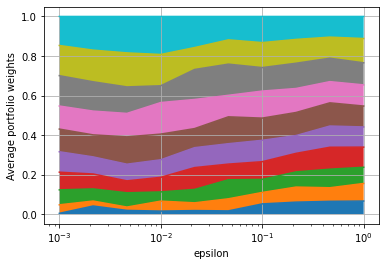

In [73]:
plt.figure(1)
plt.clf()

legend = []
for i in range (m):
    plt.xscale('log')
    plt.plot(eps_scale, xi_print_list[i])
    if i == 0:
        plt.fill_between(eps_scale, xi_print_list[i],0)
    
    if i > 0:
        plt.fill_between(eps_scale, xi_print_list[i-1], xi_print_list[i])
#     legend += ['x'+ str(i)]

plt.xlabel('epsilon')
plt.ylabel('Average portfolio weights')

plt.grid()
plt.show()
